# PyTorch Solution: Rolling Window


以下をベースに改変
https://www.kaggle.com/code/mayukh18/pytorch-fog-end-to-end-baseline-lb-0-254
改変内容
・アーキテクチャ部分
・M1Macbook対応
・学習結果のグラフ化　など

<課題>
ウェアラブルデバイスから得られる3種の波形からパーキンソン病の運動症状に関連する3種の行動を予測する
時系列データはCSVファイルに格納されており、細部が異なる2環境でのデータ,deFOGとtdcsFOGが利用可能
ラベルのアノテーションが正確なデータと不正確なものが混在する点に注意する

<方針>
被験者ごとに計測回数およびCSVファイル数が異なるため、データセットの分割にStratified Group K Foldを用いる
データセットは行動を予測したい時刻の前後数秒のデータを入力として用いるように設計
Configクラス内で設定。モデル設計のみFOGModelクラス内で直接行う

In [6]:
import os
import gc
import random
import time
import math

import json
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, average_precision_score

import warnings
warnings.filterwarnings(action='ignore')

In [7]:
class Config:
    batch_size = 32
    num_epochs = 8
    lr = 0.00015
        
    num_workers = 5
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = "mps"
        num_workers = 0
    else:
        device = 'cpu'
    
    feature_list = ['AccV', 'AccML', 'AccAP']
    label_list = ['StartHesitation', 'Turn', 'Walking']
    
    ###学習に用いる時系列データの範囲指定###
    #生データのサンプリング周波数
    Hz = 128
    
    #Option
    #合計何秒間のデータから予測するか
    window_second = 3
    #元データから何個ごとにサンプリングするか(128Hzのため全データを用いるのは冗長)
    wx = 2
    #予測時刻より未来のデータが占める割合
    future_rate = 1/3
    
    #window_size : 実際にモデルへ入力する時系列データの長さ
    window_size = int(window_second*Hz/wx)
    window_future = int(window_size*future_rate)
    window_past = window_size - window_future
    
    
cfg = Config()

# Stratified Group K Fold

付属のメタデータに各データの被験者や被験者の治療状況などが記載されているため、これらを元に交差検証用のデータセット分割を行う

### tdcsfog

In [9]:
#パス設定
root = "/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction"

train_dir = root+"/train"
test_dir = root+"/test"
unlabeled_dir = root+"/unlabeled"

train_tdcsfog_path = train_dir + "/tdcsfog"
train_defog_path = train_dir+ "/defog"
train_unlabeled_path = train_dir+ "/unlabeled"

train_metadata_path = "/kaggle/input/copy-train-metadata"

メタデータは以下のような構成

In [68]:
metadata = pd.read_csv(f"{train_metadata_path}/tdcsfog_metadata.csv")
metadata.head()

,Id,Subject,Visit,Test,Medication
0,003f117e14,13abfd,3,2,on
1,009ee11563,d81e3a,4,2,on
2,011322847a,203e85,2,2,on
3,01d0fe7266,203e85,2,1,off
4,024418ba39,cecfb8,19,3,on


予測すべき行動, StartHesitation, Turn, Walking の発生回数を各データに追加

In [10]:
#一時的
n1_sum = []
n2_sum = []
n3_sum = []
count = []

metadata = pd.read_csv(f"{train_metadata_path}/tdcsfog_metadata.csv")

for f in tqdm(metadata['Id']):
    fpath = f"{train_tdcsfog_path}/{f}.csv"
    df = pd.read_csv(fpath)
    
    n1_sum.append(np.sum(df['StartHesitation']))
    n2_sum.append(np.sum(df['Turn']))
    n3_sum.append(np.sum(df['Walking']))
    count.append(len(df))
    

metadata['n1_sum'] = n1_sum
metadata['n2_sum'] = n2_sum
metadata['n3_sum'] = n3_sum
metadata['count'] = count

100%|██████████| 833/833 [00:09<00:00, 89.18it/s] 

32 files have positive values in all 3 classes


追加後は以下のようになる

In [11]:
metadata

,Id,Subject,Visit,Test,Medication,n1_sum,n2_sum,n3_sum,count
0,003f117e14,13abfd,3,2,on,0,788,0,4682
1,009ee11563,d81e3a,4,2,on,0,4341,0,9920
2,011322847a,203e85,2,2,on,0,281,0,5187
3,01d0fe7266,203e85,2,1,off,0,200,0,7120
4,024418ba39,cecfb8,19,3,on,0,0,0,5254
...,...,...,...,...,...,...,...,...,...
828,feba449e1a,47860d,19,1,on,0,0,0,8571
829,ff4f844fd3,43fcae,2,3,on,200,1972,0,15961
830,ff53514514,a2a051,2,3,on,0,0,0,8397
831,ff92d9244d,a9e866,20,2,on,7654,44382,35979,89619


K Foldを行い、ベストな分割を用いる

In [12]:
sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
#Subject(被験者)をグループの単位として データのIDを分割
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    
    print(f"Length of Train = {len(train_index)}, Length of Valid = {len(valid_index)}")
    n1_sum = metadata.loc[train_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[train_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[train_index, 'n3_sum'].sum()
    print(f"Train classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")
    
    n1_sum = metadata.loc[valid_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[valid_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[valid_index, 'n3_sum'].sum()
    print(f"Valid classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")

Fold = 0
Length of Train = 672, Length of Valid = 161
Train classes: 287,832, 1,462,652, 175,633
Valid classes: 16,958, 216,130, 32,205
Fold = 1
Length of Train = 613, Length of Valid = 220
Train classes: 51,748, 909,505, 65,242
Valid classes: 253,042, 769,277, 142,596
Fold = 2
Length of Train = 703, Length of Valid = 130
Train classes: 271,881, 1,332,746, 183,673
Valid classes: 32,909, 346,036, 24,165
Fold = 3
Length of Train = 649, Length of Valid = 184
Train classes: 303,710, 1,517,147, 205,196
Valid classes: 1,080, 161,635, 2,642
Fold = 4
Length of Train = 695, Length of Valid = 138
Train classes: 303,989, 1,493,078, 201,608
Valid classes: 801, 185,704, 6,230


In [13]:
#Fold = 2をtrain/valid分割として採用
metadata = pd.read_csv(f"{train_metadata_path}/tdcsfog_metadata.csv")
sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    if i != 2:
        continue
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    print(f"Length of Train = {len(train_ids)}, Length of Valid = {len(valid_ids)}")
    
    if i == 2:
        break
        
train_fpaths_tdcs = [f"{train_tdcsfog_path}/{_id}.csv" for _id in train_ids]
valid_fpaths_tdcs = [f"{train_tdcsfog_path}/{_id}.csv" for _id in valid_ids]

Fold = 2
Length of Train = 703, Length of Valid = 130


### defog

In [14]:
# Analysis of positive instances in each fold of our CV folds

n1_sum = []
n2_sum = []
n3_sum = []
count = []

# Here I am using the metadata file available during training. Since the code will run again during submission, if 
# I used the usual file from the competition folder, it would have been updated with the test files too.
metadata = pd.read_csv(f"{train_metadata_path}/defog_metadata.csv")
metadata['n1_sum'] = 0
metadata['n2_sum'] = 0
metadata['n3_sum'] = 0
metadata['count'] = 0

for f in tqdm(metadata['Id']):
    fpath = f"{train_defog_path}/{f}.csv"
    if os.path.exists(fpath) == False:
        continue
        
    df = pd.read_csv(fpath)
    metadata.loc[metadata['Id'] == f, 'n1_sum'] = np.sum(df['StartHesitation'])
    metadata.loc[metadata['Id'] == f, 'n2_sum'] = np.sum(df['Turn'])
    metadata.loc[metadata['Id'] == f, 'n3_sum'] = np.sum(df['Walking'])
    metadata.loc[metadata['Id'] == f, 'count'] = len(df)
    
metadata = metadata[metadata['count'] > 0].reset_index()

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    
    print(f"Length of Train = {len(train_index)}, Length of Valid = {len(valid_index)}")
    n1_sum = metadata.loc[train_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[train_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[train_index, 'n3_sum'].sum()
    print(f"Train classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")
    
    n1_sum = metadata.loc[valid_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[valid_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[valid_index, 'n3_sum'].sum()
    print(f"Valid classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")

# FOLD 2 is the most well balanced
# The actual train-test split (based on Fold 2)

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    if i != 1:
        continue
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    print(f"Length of Train = {len(train_ids)}, Length of Valid = {len(valid_ids)}")
    
    if i == 2:
        break
        
train_fpaths_de = [f"{train_defog_path}/{_id}.csv" for _id in train_ids]
valid_fpaths_de = [f"{train_defog_path}/{_id}.csv" for _id in valid_ids]

100%|██████████| 137/137 [00:08<00:00, 17.04it/s]

Fold = 0
Length of Train = 75, Length of Valid = 16
Train classes: 500, 410,998, 31,612
Valid classes: 0, 157,267, 60,789
Fold = 1
Length of Train = 65, Length of Valid = 26
Train classes: 216, 475,613, 81,579
Valid classes: 284, 92,652, 10,822
Fold = 2
Length of Train = 76, Length of Valid = 15
Train classes: 410, 470,765, 83,170
Valid classes: 90, 97,500, 9,231
Fold = 3
Length of Train = 70, Length of Valid = 21
Train classes: 435, 413,452, 84,247
Valid classes: 65, 154,813, 8,154
Fold = 4
Length of Train = 78, Length of Valid = 13
Train classes: 439, 502,232, 88,996
Valid classes: 61, 66,033, 3,405
Fold = 1
Length of Train = 65, Length of Valid = 26


In [15]:
train_fpaths = [(f, 'de') for f in train_fpaths_de] + [(f, 'tdcs') for f in train_fpaths_tdcs]
valid_fpaths = [(f, 'de') for f in valid_fpaths_de] + [(f, 'tdcs') for f in valid_fpaths_tdcs]

# Dataset

1つのCSVファイルは以下のような構成

In [69]:
df = pd.read_csv(train_fpaths_tdcs[0])
df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.533939,0.566322,-1.413525,0,0,0
1,1,-9.536140,0.564137,-1.440621,0,0,0
2,2,-9.529345,0.561765,-1.429332,0,0,0
3,3,-9.531239,0.564227,-1.415490,0,0,0
4,4,-9.540825,0.561854,-1.429471,0,0,0


Configで元データからサンプリングする際の感覚wxを決定するために、元データの一部を可視化する

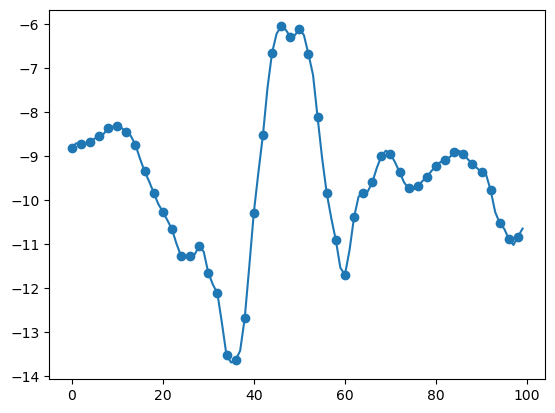

In [16]:
import matplotlib.pyplot as plt

df = pd.read_csv(train_fpaths_tdcs[0])
wave = df["AccV"].to_numpy()
start_time = 1000
end_time = 1100
test_wx = 2
plt.plot(wave[start_time:end_time])
plt.scatter(np.arange(end_time-start_time)[::test_wx],wave[start_time:end_time][::test_wx])

In [63]:
class FOGDataset(Dataset):
    def __init__(self, fpaths, split="train"):
        super().__init__()
            
        tm = time.time()
        self.split = split
        self.fpaths = fpaths
        self.dfs = [self.read(f[0], f[1]) for f in self.fpaths]
        self.f_ids = [os.path.basename(f[0])[:-4] for f in self.fpaths]
        
        self.end_indices = []
        self.shapes = []
        _length = 0
        for df in self.dfs:
            self.shapes.append(df.shape[0])
            _length += df.shape[0]
            self.end_indices.append(_length)
        
        #全CSVファイルのデータは仕様を簡便にするため結合して扱う。したがって、不連続なつなぎめを持つ不適切な学習データも一部発生する
        self.dfs = np.concatenate(self.dfs, axis=0).astype(np.float16)
        self.length = self.dfs.shape[0]
        
        shape1 = self.dfs.shape[1]
        
        self.dfs = np.concatenate([np.zeros((cfg.wx*cfg.window_past, shape1)),
                                   self.dfs,
                                   np.zeros((cfg.wx*cfg.window_future, shape1))
                                  ], axis=0)
        print(f"Dataset initialized in {time.time() - tm} secs!")
        gc.collect()

    #データ取得環境に依存する項目の違いを反映させる
    def read(self, f, _type):
        df = pd.read_csv(f)
        if self.split == "test":
            return np.array(df)
        
        if _type =="tdcs":
            df['Valid'] = 1
            df['Task'] = 1
            df['tdcs'] = 1
        else:
            df['tdcs'] = 0
        
        return np.array(df)
        

    def __getitem__(self, index):
        if self.split == "train":
            #学習時はランダムに時刻を取得する
            row_idx = random.randint(0, self.length-1) + cfg.wx*cfg.window_past
        elif self.split == "test":
            for i,e in enumerate(self.end_indices):
                if index >= e:
                    continue
                df_idx = i
                break
            #df_idx番目のCSVファイルのうち何番目のタイムステップがrow_idxにあたるのかを求める
            row_idx_true = self.shapes[df_idx] - (self.end_indices[df_idx] - index)
            _id = self.f_ids[df_idx] + "_" + str(row_idx_true)
            row_idx = index + cfg.wx*cfg.window_past
        elif self.split == "valid":
            row_idx = index + cfg.wx*cfg.window_past
        else:
            assert()
            
        #AccV,AccML,AccAP
        x = self.dfs[row_idx - cfg.wx*cfg.window_past : row_idx + cfg.wx*cfg.window_future, 1:4]
        #cfg.wx個ごとにデータ点を取得
        x = x[::cfg.wx, :][::-1, :]
        x = torch.tensor(x.astype(np.float32))
        x = x.permute(1,0)
        
        #tが1の時、正確に行動をアノテーションされたデータである
        #(Valid) * (Task)
        t = self.dfs[row_idx, -3]*self.dfs[row_idx, -2]
        t = t.astype(np.float32)
        
        if self.split == "test":
            return _id, x, t
        
        #StartHesitation,Turn,Walking
        y = self.dfs[row_idx, 4:7]
        y = torch.tensor(y.astype(np.float32))
        return x, y, t
    
    def __len__(self):
        '''
        # return self.length
        if self.split == "train":
            return 5_000_000
        '''
        return self.length

In [19]:
#ガベージコレクションを明示的に起動
gc.collect()

0

# Model

CNNを音声データなどの時系列データの学習に用いる際の手法のうち、
レイヤー数に対し指数関数的に入力データ長を処理できるdilatedCNNを導入
その後特徴量圧縮のため一般的なCNNと全結合層を接続
リアルタイム処理ではないため過去と未来の情報は等価に扱う

In [25]:
class FOGModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_dim = 3
        dil_channel = [input_dim,16,32,64,64,64]
        dil_r = 2
        dil_layer = 5
        dil_kernel_size = 5
        
        pooling_channel = [dil_channel[-1],32,16]
        poolig_kernel_size = 2
        pooling_layer = 2
        pooling_kernel_size = 2
        
        #全結合層のinput sizeを計算
        input_length = cfg.window_size
        for i in range(dil_layer):
            input_length -= (dil_kernel_size - 1)*2**i
        for i in range(pooling_layer):
            input_length = math.ceil((input_length - pooling_kernel_size)/2)

        self.fc_input = input_length*pooling_channel[-1]
        
        #common
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.sigmoid = nn.Sigmoid()

        #Dilated CNN
        self.dilation_list = nn.ModuleList([
            nn.Conv1d(dil_channel[i],
                      dil_channel[i+1],
                      kernel_size = dil_kernel_size,
                      padding = "valid",
                      dilation = dil_r**i) for i in range(dil_layer)
        ])
        #CNN
        self.pooling_list = nn.ModuleList([
            nn.Conv1d(pooling_channel[i],
                      pooling_channel[i+1],
                      kernel_size = pooling_kernel_size,
                      padding="valid",
                      dilation = 1) for i in range(pooling_layer)
        ])

        #dense
        self.fc1 = nn.Linear(self.fc_input, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,3)
        #self.fc1 = nn.Linear(sum(num_filters), 1)
        
    def forward(self, x):
        for conv_layer in self.dilation_list:
            x = conv_layer(x)
            x = self.relu(x)
            
        for conv_layer in self.pooling_list:
            x = conv_layer(x)
            x = self.relu(x)
            x = self.pool(x)
        #dense
        x = x.view(x.size(0),-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training

In [59]:
def train_one_epoch(model,train_loader,optimizer,criterion):
    loss_sum = 0.
    y_true_epoch = []
    y_pred_epoch = []
    t_epoch = []
    model.train()
    for x,y,t in tqdm(train_loader):
        with torch.no_grad():
            t_sum = torch.sum(t)
            if t_sum <= 0:
                continue

        x = x.to(cfg.device).float()
        y = y.to(cfg.device).float()
        t = t.to(cfg.device).float()

        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss = torch.mean(loss*t.unsqueeze(-1), dim=1)

        t_sum = torch.sum(t)
        if t_sum > 0:
            loss = torch.sum(loss)/t_sum
        else:
            loss = torch.sum(loss)*0.

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        loss_sum += loss.item()

        y_true_epoch.append(y.detach().cpu().numpy())
        y_pred_epoch.append(y_pred.detach().cpu().numpy())
        t_epoch.append(t.detach().cpu().numpy())
        
    y_true_epoch = np.concatenate(y_true_epoch, axis=0)
    y_pred_epoch = np.concatenate(y_pred_epoch, axis=0)
    
    t_epoch = np.concatenate(t_epoch, axis=0)
    y_true_epoch = y_true_epoch[t_epoch > 0, :]
    y_pred_epoch = y_pred_epoch[t_epoch > 0, :]
    
    scores = [average_precision_score(y_true_epoch[:,i], y_pred_epoch[:,i]) for i in range(3)]
    mean_score = np.mean(scores)
        
    loss_log.append(loss_sum)
    print(f"Train Loss: {(loss_sum/len(train_loader)):.04f}, Train Score:{mean_score:.03f}, ClassWise: {scores[0]:.03f},{scores[1]:.03f},{scores[2]:.03f}")
    return mean_score,loss_sum/len(train_loader)
      
    

def validation_one_epoch(model, loader, criterion):
    loss_sum = 0.
    y_true_epoch = []
    y_pred_epoch = []
    t_valid_epoch = []
    
    model.eval()
    for x,y,t in tqdm(loader):
        x = x.to(cfg.device).float()
        y = y.to(cfg.device).float()
        t = t.to(cfg.device).float()
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss = torch.mean(loss*t.unsqueeze(-1), dim=1)
            
            t_sum = torch.sum(t)
            if t_sum > 0:
                loss = torch.sum(loss)/t_sum
            else:
                loss = torch.sum(loss)*0.
        
        loss_sum += loss.item()
        y_true_epoch.append(y.cpu().numpy())
        y_pred_epoch.append(y_pred.cpu().numpy())
        t_valid_epoch.append(t.cpu().numpy())
        
    y_true_epoch = np.concatenate(y_true_epoch, axis=0)
    y_pred_epoch = np.concatenate(y_pred_epoch, axis=0)
    
    t_valid_epoch = np.concatenate(t_valid_epoch, axis=0)
    y_true_epoch = y_true_epoch[t_valid_epoch > 0, :]
    y_pred_epoch = y_pred_epoch[t_valid_epoch > 0, :]
    
    scores = [average_precision_score(y_true_epoch[:,i], y_pred_epoch[:,i]) for i in range(3)]
    mean_score = np.mean(scores)
    print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}, ClassWise: {scores[0]:.03f},{scores[1]:.03f},{scores[2]:.03f}")
    
    return mean_score, loss_sum/len(loader)

In [ ]:
model = FOGModel().to(cfg.device)
print(f"Number of parameters in model - {count_parameters(model):,}")

#train_dataset = FOGDataset(train_fpaths, split="train")
train_dataset = FOGDataset(valid_fpaths, split="train")
valid_dataset = FOGDataset(valid_fpaths, split="valid")


train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=cfg.num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=cfg.batch_size, num_workers=cfg.num_workers)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none').to(cfg.device)

print("="*50)
train_score_log = []
train_loss_log = []
valid_score_log = []
valid_loss_log = []
for epoch in range(cfg.num_epochs):
    print(f"Epoch: {epoch}")
    train_score, train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    valid_score, valid_loss = validation_one_epoch(model, valid_loader, criterion)
    
    train_score_log.append(train_score)
    train_loss_log.append(train_loss)
    valid_score_log.append(valid_score)
    valid_loss_log.append(valid_loss)
    print("="*50)

torch.save(model.state_dict(), "model.pth")


plt.plot(train_score_log,label="train")
plt.plot(valid_score_log,label="valid")
plt.title("score")
plt.legend()
plt.show()

plt.plot(train_loss_log,label="train")
plt.plot(valid_loss_log,label="valid")
plt.title("loss")
plt.legend()
plt.show()

gc.collect()